In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, PReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [2]:
# Define la función FSRCNN
def FSRCNN(scale_factor, input_shape=(64, 64, 3)):  # Cambiar a 3 canales para imágenes en color
    inputs = Input(shape=input_shape)

    # Feature extraction
    x = Conv2D(64, (5, 5), padding='same')(inputs)
    x = PReLU()(x)
    
    # Shrinking
    x = Conv2D(16, (1, 1), padding='same')(x)
    x = PReLU()(x)
    
    # Non-linear mapping
    for _ in range(6):  # Aumentar el número de capas de mapeo no lineal
        x = Conv2D(16, (3, 3), padding='same')(x)
        x = PReLU()(x)
    
    # Expanding
    x = Conv2D(64, (1, 1), padding='same')(x)
    x = PReLU()(x)
    
    # Deconvolution
    x = Conv2DTranspose(3, (9, 9), strides=(scale_factor, scale_factor), padding='same')(x)  # 3 canales para imágenes en color
    outputs = PReLU()(x)
    
    model = Model(inputs, outputs)
    return model

# Crear el modelo FSRCNN
model = FSRCNN(scale_factor=4, input_shape=(64, 64, 3))  # Usar factor de escala 4 para 64x64 a 256x256
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [3]:
# Preparar datos para el entrenamiento
def load_dataset(low_res_dir, high_res_dir):
    low_res_images = []
    high_res_images = []

    for filename in os.listdir(low_res_dir):
        low_res_image_path = os.path.join(low_res_dir, filename)
        high_res_image_name = filename.split('_blur')[0].split('_64x64')[0] + '_256x256.png'
        high_res_image_path = os.path.join(high_res_dir, high_res_image_name)
        
        # Verificar si el archivo de alta resolución existe
        if os.path.exists(high_res_image_path):
            low_res_image = load_img(low_res_image_path)  # No convertir a escala de grises
            high_res_image = load_img(high_res_image_path)  # No convertir a escala de grises

            low_res_images.append(img_to_array(low_res_image) / 255.0)
            high_res_images.append(img_to_array(high_res_image) / 255.0)
        else:
            print(f"Archivo de alta resolución no encontrado para: {low_res_image_path}")

    return np.array(low_res_images), np.array(high_res_images)

# Cargar los datos
base_dir = r'C:\Users\lina-\Documents\ProyectoComputacion\Proyecto\dataset2'
x_train, y_train = load_dataset(os.path.join(base_dir, 'train/low_res'), os.path.join(base_dir, 'train/high_res'))
x_val, y_val = load_dataset(os.path.join(base_dir, 'validation/low_res'), os.path.join(base_dir, 'validation/high_res'))

# Asegurarse de que los datos tienen la forma correcta
x_train = x_train.reshape(-1, 64, 64, 3)  # Cambiar a 3 canales
y_train = y_train.reshape(-1, 256, 256, 3)  # Cambiar a 3 canales
x_val = x_val.reshape(-1, 64, 64, 3)  # Cambiar a 3 canales
y_val = y_val.reshape(-1, 256, 256, 3)  # Cambiar a 3 canales


In [7]:
# Callbacks para el entrenamiento
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback personalizado para monitorear PSNR y SSIM
class MonitorPSNRandSSIM(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MonitorPSNRandSSIM, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        val_y_pred = self.model.predict(val_x)

        psnr_values = [psnr(val_y[i], val_y_pred[i], data_range=1.0) for i in range(len(val_y))]
        ssim_values = [ssim(val_y[i], val_y_pred[i], multichannel=True, data_range=1.0, win_size=11, channel_axis=-1) for i in range(len(val_y))]

        mean_psnr = np.mean(psnr_values)
        mean_ssim = np.mean(ssim_values)

        print(f"Epoch {epoch+1}: PSNR: {mean_psnr:.4f}, SSIM: {mean_ssim:.4f}")

In [8]:
# Entrenar el modelo con más información
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,  # Aumentar el número de épocas
    batch_size=16,
    callbacks=[tensorboard_callback, checkpoint_callback, MonitorPSNRandSSIM((x_val, y_val))]
)

Epoch 1/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0140
Epoch 1: val_loss improved from inf to 0.01114, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Epoch 1: PSNR: 20.2374, SSIM: 0.6227
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 0.0140 - val_loss: 0.0111
Epoch 2/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0099
Epoch 2: val_loss improved from 0.01114 to 0.01044, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Epoch 2: PSNR: 20.5652, SSIM: 0.6736
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step - loss: 0.0099 - val_loss: 0.0104
Epoch 3/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0089
Epoch 3: val_loss improved from 0.01044 to 0.00646, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Epoch 3: PSNR: 22.4508, SSIM: 0.6892
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - loss: 0.0089 - val_loss: 0.0065
Epoch 4/100
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0055
Epoch 4: val_loss imp

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0024
Loss en el conjunto de prueba: 0.0023179720155894756
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0281407].


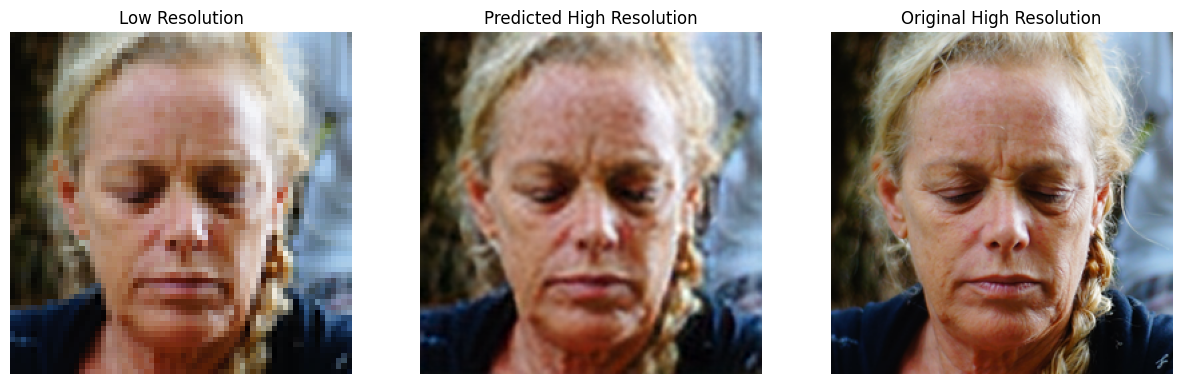

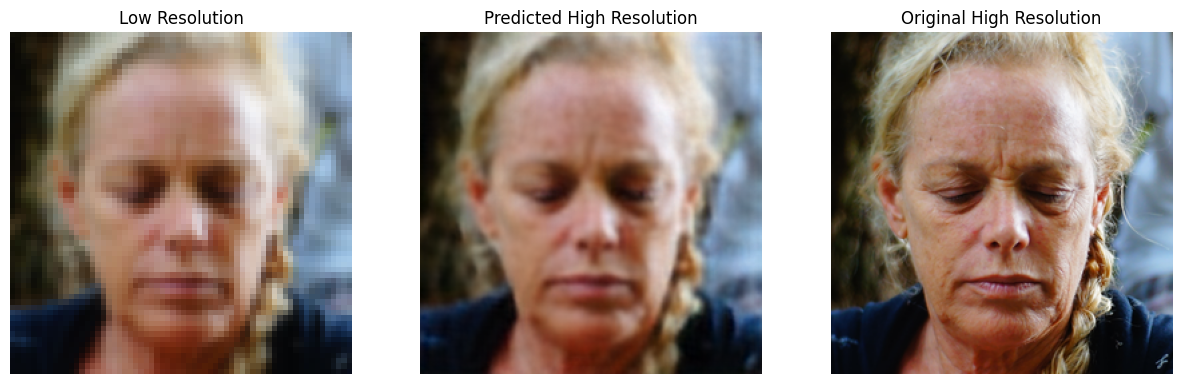

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.6706584e-08..1.1331037].


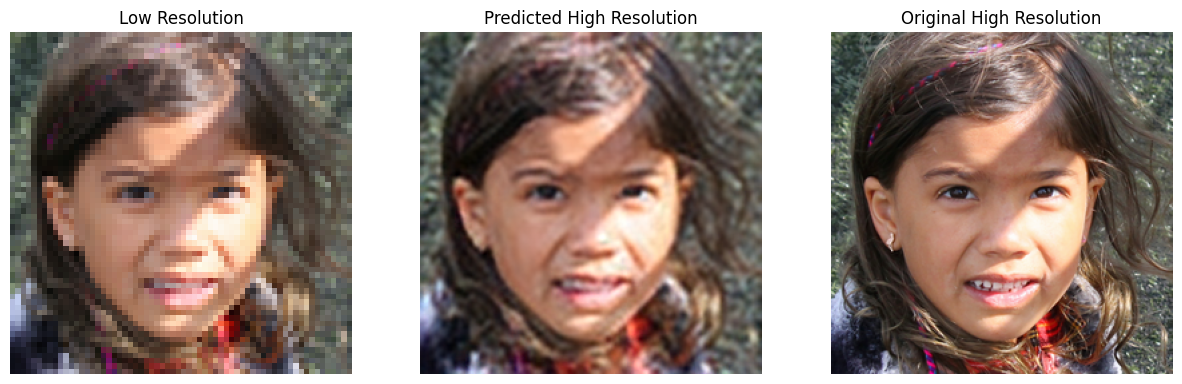

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016890373..1.0393449].


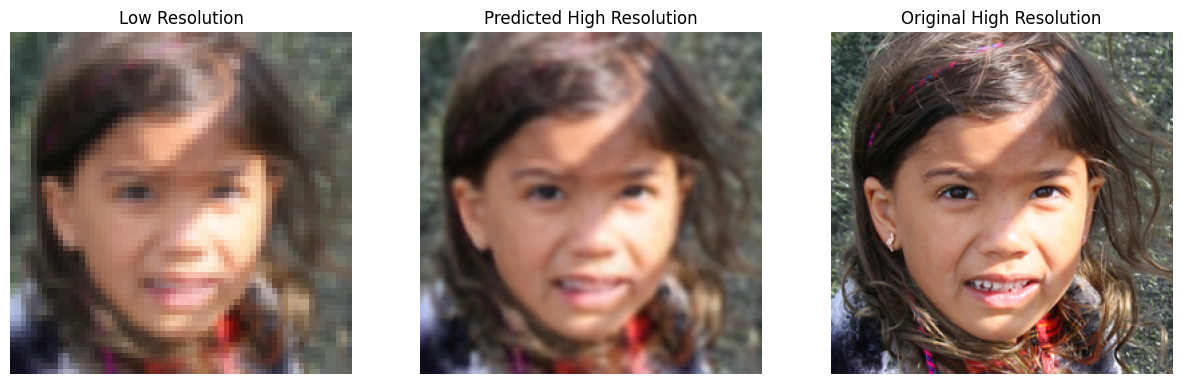

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.453502e-11..1.2283139].


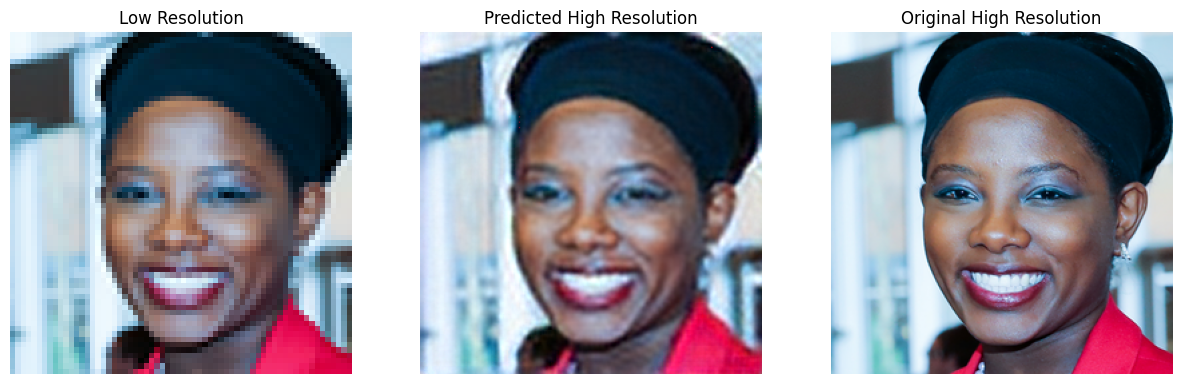

In [13]:
# Evaluar el modelo y mostrar resultados
x_test, y_test = load_dataset(os.path.join(base_dir, 'test/low_res'), os.path.join(base_dir, 'test/high_res'))
x_test = x_test.reshape(-1, 64, 64, 3)  # Cambiar a 3 canales
y_test = y_test.reshape(-1, 256, 256, 3)  # Cambiar a 3 canales
loss = model.evaluate(x_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}')

# Función para predecir y mostrar resultados
def predict_and_show(model, x_test, y_test, num_images=5):
    predictions = model.predict(x_test[:num_images])

    for i in range(num_images):
        low_res_image = x_test[i].reshape(64, 64, 3)
        high_res_image = y_test[i].reshape(256, 256, 3)
        predicted_image = predictions[i].reshape(256, 256, 3)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Low Resolution')
        plt.imshow(low_res_image)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Predicted High Resolution')
        plt.imshow(predicted_image)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Original High Resolution')
        plt.imshow(high_res_image)
        plt.axis('off')

        plt.show()

# Predecir y mostrar resultados
predict_and_show(model, x_test, y_test, num_images=5)

In [14]:
# Guardar el modelo entrenado al final del entrenamiento
model.save('fsrcnn_model_color.h5')

In [15]:
# Guardar el modelo en formato .pb
tf.saved_model.save(model, "saved_model/fsrcnn_model_color_")

INFO:tensorflow:Assets written to: saved_model/fsrcnn_model_color_\assets


INFO:tensorflow:Assets written to: saved_model/fsrcnn_model_color_\assets
